# <font color=#B2D732> <span style="background-color: #4424D6">  Spinal cord fMRI denoising </font>

@ author of the script:  <font color=#B2D732> Caroline Landelle </font>, caroline.landelle@mcgill.ca // landelle.caroline@gmail.com   

**Description:** This notebook provides code for BOLD signal fMRI denoising, template registration and smoothing  
The pipeline was adapted from Landelle et al. 2025 (preprint): https://github.com/CarolineLndl/Landelle_spinebrain_aging

*For each individual, we accounted for the physiological and other noise sources by modeling nuisance noises present in CSF and by collecting physiological data using the Tapas PhysiO toolbox (Kasper et al., 2017). First, we used the RETROspective Image CORrection (RETROICOR) procedure (Glover et al., 2000) [..] Second, [...] we used the CompCor (Behzadi et al., 2007) approach [...]. Finally, we applied a bandpass filter 0.01-0.17 Hz to emphasize low-frequency signals of interest.*

> <font color=#B2D732> **I.** </font> **Extract slice wise motion parameters**  
> <font color=#B2D732> **II.** </font> **Compute outliers calculation**  
> <font color=#B2D732> **III.** </font> **Physiological noise modeling: Retroicor**  
> <font color=#B2D732> **IV.** </font> **DCT calculation**  
> <font color=#B2D732> **V.** </font> **Signal cleaning**  
> <font color=#B2D732> **VI.** </font> **Normalization to template**  
> <font color=#B2D732> **VII.** </font> **Smoothing**  

**Toolbox required:** Tapas PhysiO Toolbox (SPM, Matlab) , nilearn (Python), FSL (bash)  
https://github.com/translationalneuromodeling/tapas/tree/master/PhysIO  
https://www.sciencedirect.com/science/article/pii/S016502701630259X  

**Inputs**:  
This notebook required the following data:
- preprossed anatomical, fmri images and physiological recordings


**Ouputs**:
See the output description at each step of the Notebook.

## <font color=#B2D732> <span style="background-color: #4424D6"> Initialization </font>  
Before running the script you should create a config.json file with the right pathways

In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Main imports ------------------------------------------------------------
import json,sys, os, glob

import nibabel as nb
import pandas as pd
import matlab.engine

# Load config file ------------------------------------------------------------
with open('/cerebro/cerebro1/dataset/spine_7T/spine_7T_analysis/config/config_preprocess_spine7T.json') as config_file: # the notebook should be in 'xx/notebook/' folder #config_proprio
    config = json.load(config_file) # load config file should be open first and the path inside modified

sys.path.append(config["root_dir"] + config["tools_dir"]["main_codes"] + "/code/") # Change this line according to your directory


from brsc_denoising import Denoising
import brsc_utils as utils
from brsc_preprocess import Preprocess_Sc, Preprocess_BrSc

denoising=Denoising(config)
preprocess_Sc=Preprocess_Sc(config)
preprocess_BrSc=Preprocess_BrSc(config)

#----- Select specificity for each individuals
design_exp={}


for ID in config["participants_IDs"]:
    design_exp[ID]={}
    for task_name in config["design_exp"]["task_names"]:
        for acq_name in config["design_exp"]["acq_names"]:
            design_exp[ID]["task-" + task_name + "_acq-" + acq_name]=[]
            tag="task-" + task_name + "_acq-" + acq_name
        
            if tag in config.get("files_specificities", {}).get("func", {}).get(ID,{}):
                for run_name in config["files_specificities"]["func"][ID][tag]:
                    design_exp[ID][tag].append(run_name)
    
            else:
                for run_name in config["design_exp"]["run_names"][tag]:
                    design_exp[ID][tag].append(run_name)
        

participants_tsv = pd.read_csv('/cerebro/cerebro1/dataset/spine_7T/spine_7T_analysis/config/participants.tsv', sep='\t')
denoising_dir=config["root_dir"] + config["derivatives_dir"] + config["denoising"]["dir"]
preprocessing_dir=config["root_dir"] + config["derivatives_dir"] + config["preprocess_dir"]["main_dir"]

verbose=True
redo=False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The config files should be manually modified first
All the raw data should be store in BIDS format
 
sub-099 have a func filename specitity: 
{'task-motor_acq-shimSlice+3mm': ['']}
sub-100 have a func filename specitity: 
{'task-motor_acq-shimSlice+3mm': ['']}
099
/cerebro/cerebro1/dataset/spine_7T/derivatives/spine_7T_project/preprocessing/nov25/sub-099/
100
/cerebro/cerebro1/dataset/spine_7T/derivatives/spine_7T_project/preprocessing/nov25/sub-100/


## <font color=#B2D732> <span style="background-color: #4424D6"> I. Create slice wise motion parameter .tsv file  </font> </span> 

In [22]:
for ID in config["participants_IDs"]:
    for task_nb,task_name in enumerate(design_exp[ID]):
        for run_nb, run_name in enumerate(design_exp[ID][task_name]):
            denoising.moco_params(ID=ID, task_name=task_name,run_name=run_name,redo=redo)

Spinal cord moco params were already extracted please, put redo=True to recalculate it
Spinal cord moco params were already extracted please, put redo=True to recalculate it
Spinal cord moco params were already extracted please, put redo=True to recalculate it
Spinal cord moco params were already extracted please, put redo=True to recalculate it


## <font color=#B2D732> <span style="background-color: #4424D6"> II. Extract outlier volumes  </font> </span> 

In [23]:
for ID in config["participants_IDs"]:
    for task_name in config["design_exp"]["task_names"]:
        for acq_name in config["design_exp"]["acq_names"]:
            tag="task-" + task_name + "_acq-" + acq_name
            for run_nb, run_name in enumerate(design_exp[ID][tag]):
                denoising.outliers(ID=ID, task_name=tag,run_name=run_name,redo=redo)


## <font color=#B2D732> <span style="background-color: #4424D6"> III. Physiological noise modelling  </font> </span> 
#### Find and copy .tsv physio files

In [24]:
physio_files={}
for ID in config["participants_IDs"]:
    physio_files[ID]={}
    for task_name in config["design_exp"]["task_names"]:
        for acq_name in config["design_exp"]["acq_names"]:
            tag="task-" + task_name + "_acq-" + acq_name
            physio_files[ID][tag]={}
            for run_nb, run_name in enumerate(design_exp[ID][tag]):
                physio_files[ID][tag][run_name]=denoising.find_physio_file(
                    ID=ID,
                    task_name=tag,
                    run_name=run_name,
                    copy=True, # if you want to copy the data somewhere else than the rawdata directory
                    output_dir=denoising_dir + config["denoising"]["denoised_dir"].format(ID,tag), #  needed if copy=True 
                    redo=redo)


Looking for physio file in : /cerebro/cerebro1/dataset/spine_7T/rawdata//sub-099/func/
Looking for physio file in : /cerebro/cerebro1/dataset/spine_7T/rawdata//sub-099/func/
Looking for physio file in : /cerebro/cerebro1/dataset/spine_7T/rawdata//sub-100/func/
Looking for physio file in : /cerebro/cerebro1/dataset/spine_7T/rawdata//sub-100/func/


#### Run Retroicor
We used the RETROspective Image CORrection (RETROICOR) procedure (Glover et al., 2000) to generate noise regressors from peripheral physiological recordings. This method models the respiratory and cardiac phases for each functional volume. A low-order Fourier expansion was then calculated to model the physiological noise. We modeled six cardiac and eight respiratory harmonics and four multiplicative terms for the interactions between cardiac and respiratory noise, as well as one regressor for heart rate variability and one for the respiratory volume per time.
NEW !! The outputs are generated slice wise

/!\ If there is a beug like "No peaks found in raw cardiac time series. Check raw physiological recordings figure whether there is any non-constantcardiac data" it is possible that you have NaN in your physio file.

/!\ Check point: physiological recording graph: sub-XX_Physio.png 

Tapas done for 099 task-motor_acq-shimBase+3mm 
**************************************************


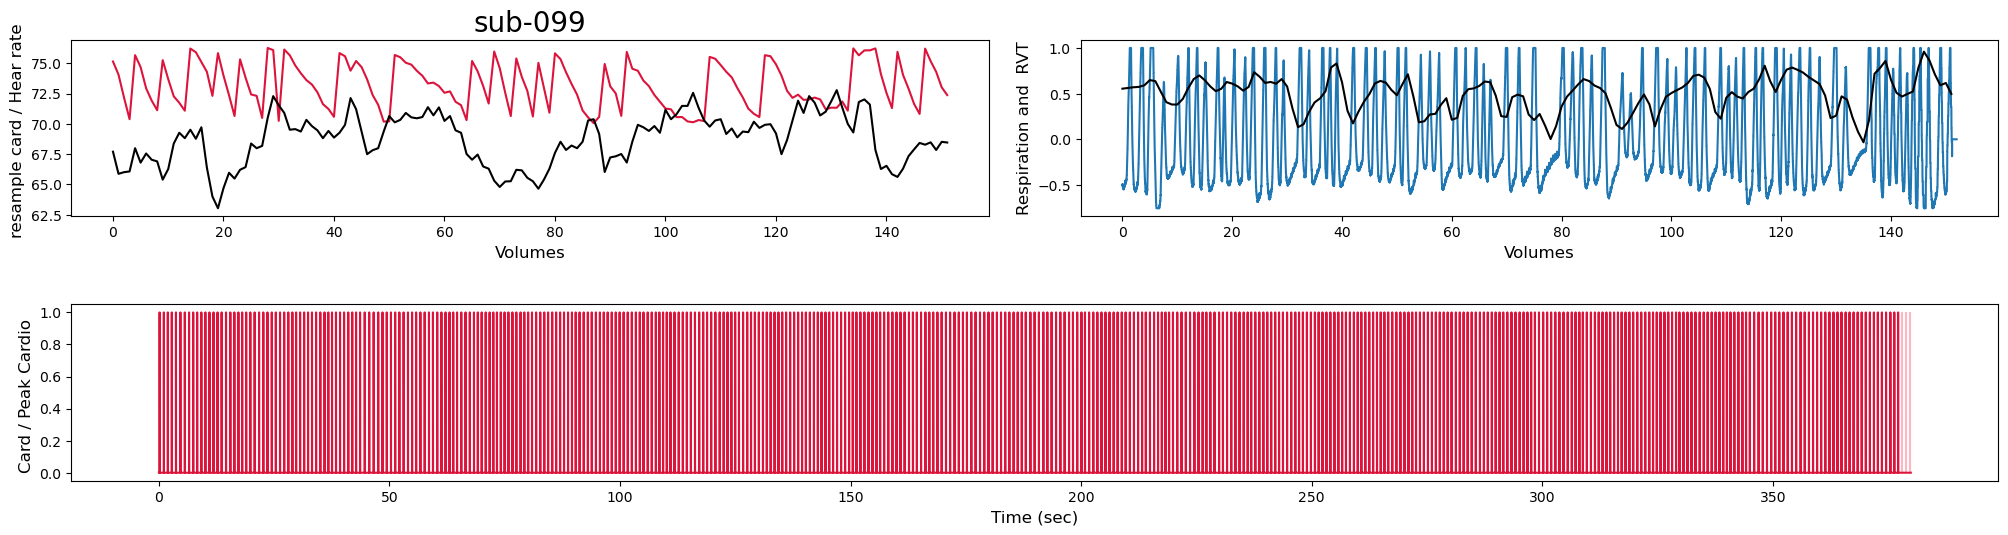

Tapas done for 099 task-motor_acq-shimSlice+3mm 
**************************************************


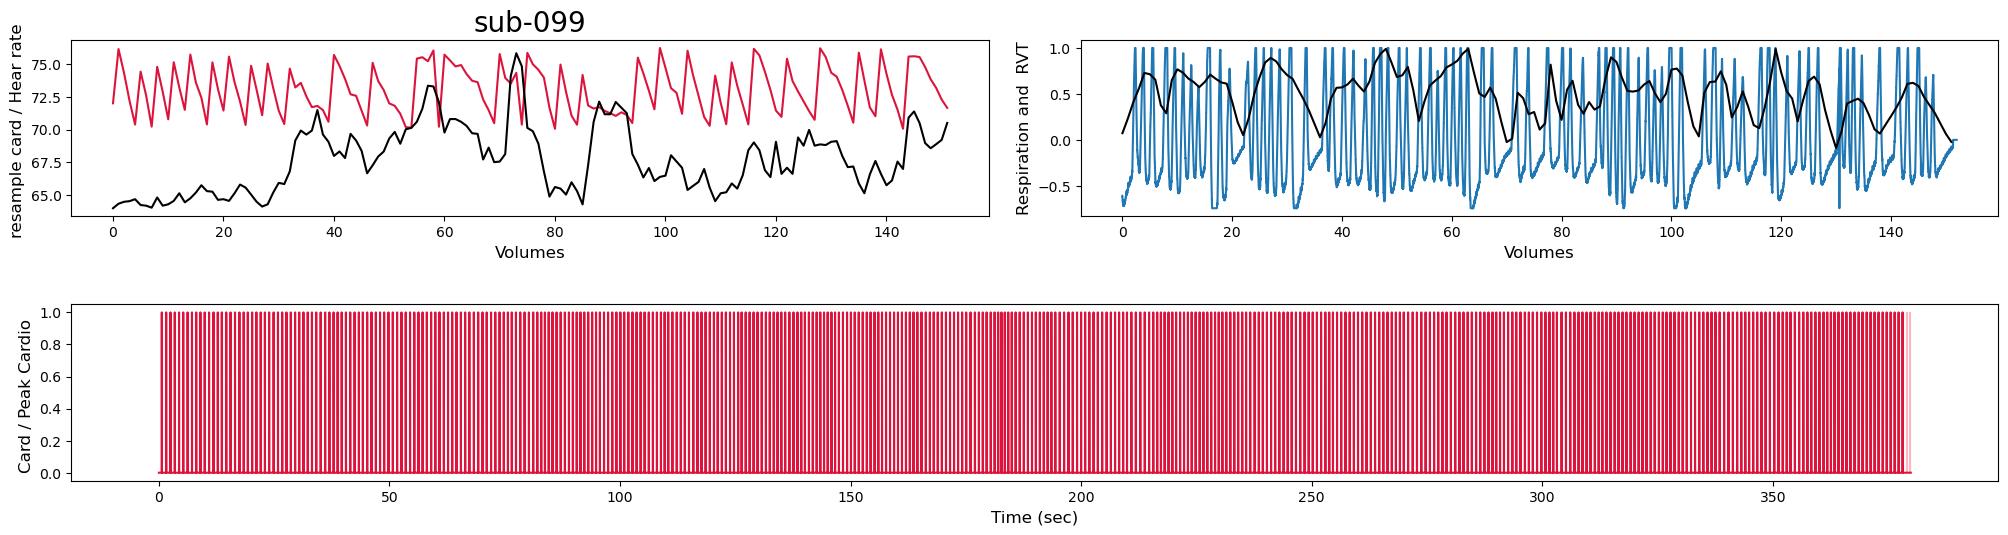

Tapas done for 100 task-motor_acq-shimBase+3mm 
**************************************************


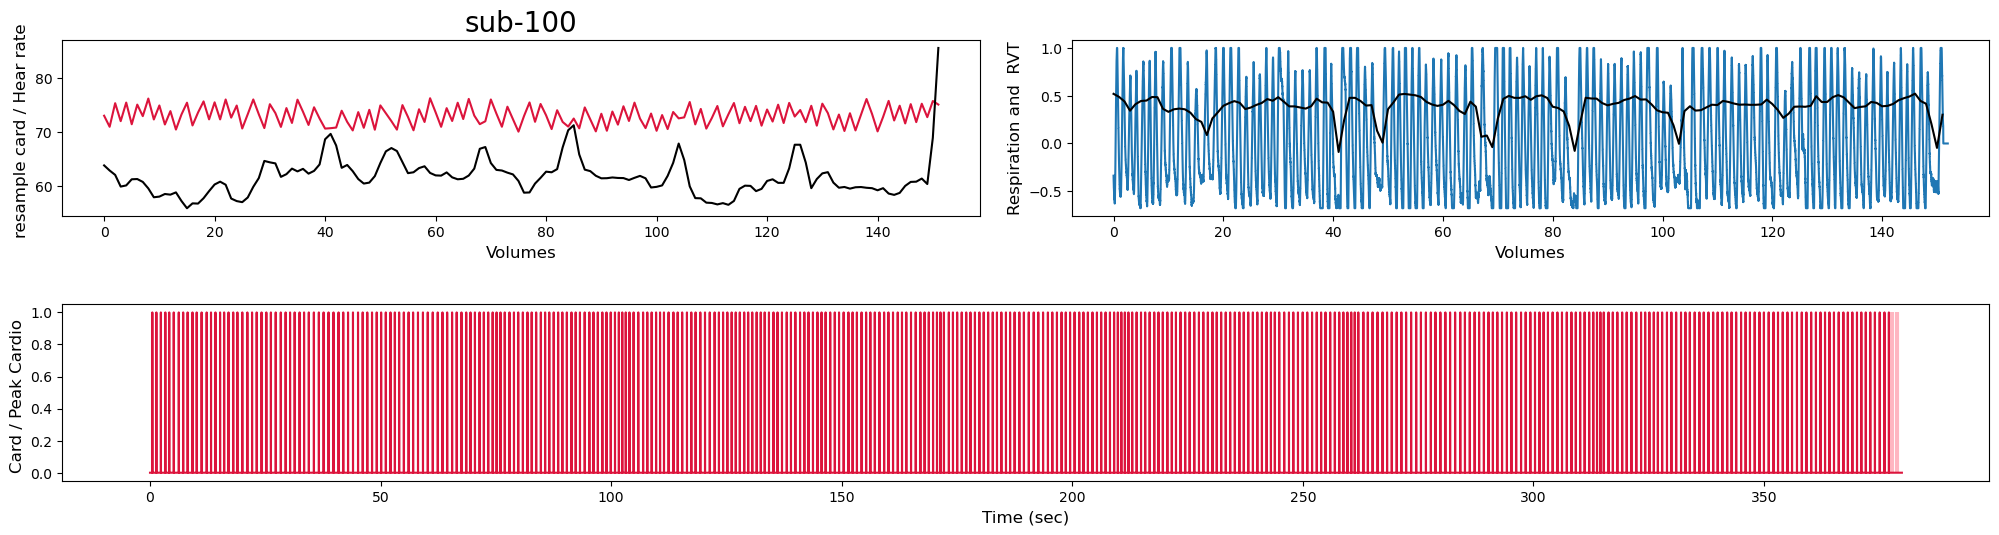

Tapas done for 100 task-motor_acq-shimSlice+3mm 
**************************************************


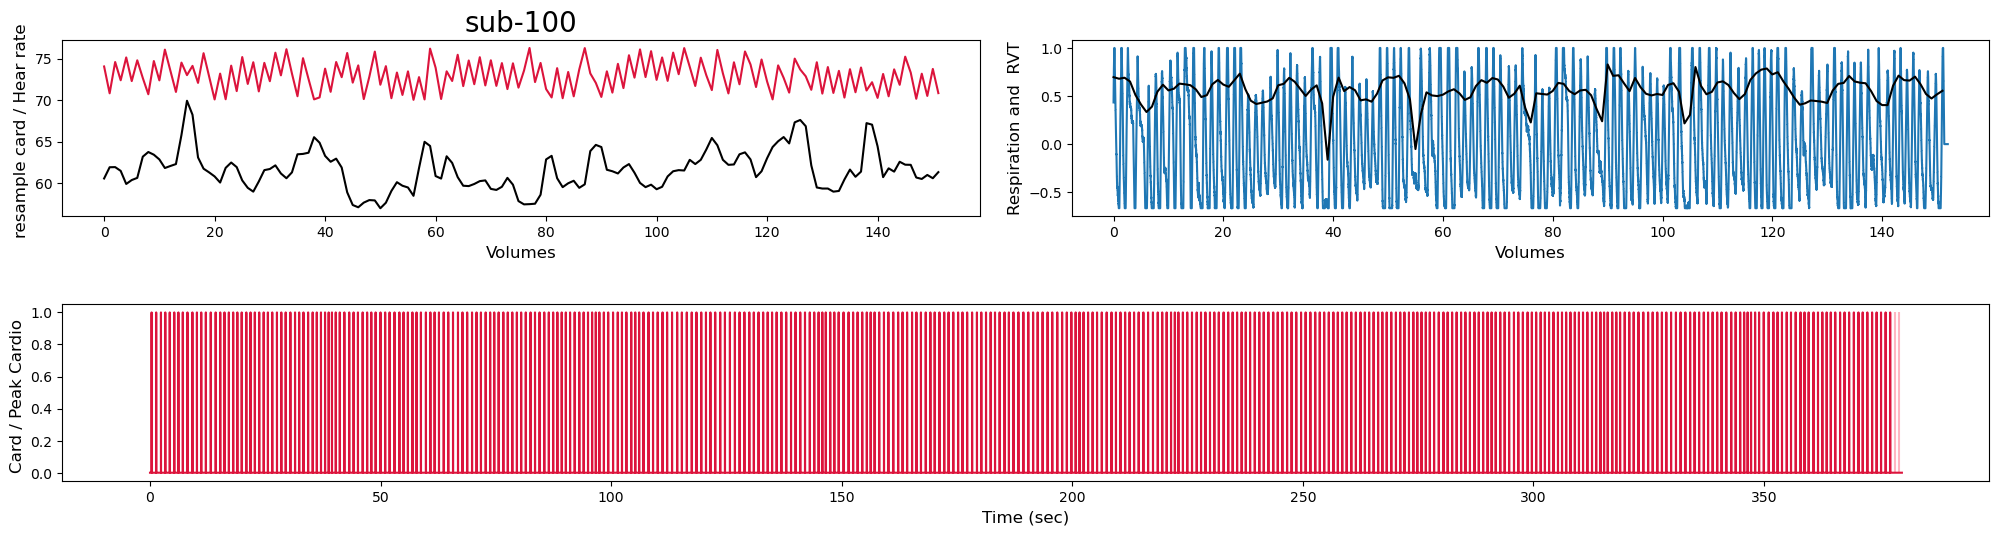

In [25]:
os.chdir(config['root_dir'] + config["tools_dir"]["main_codes"] + "/code/spm/")# need to change the directory to find the toolbox
eng = matlab.engine.start_matlab()

physio_mat={}
for ID in config["participants_IDs"]:
    physio_mat[ID]={}
    for task_name in config["design_exp"]["task_names"]:
        for acq_name in config["design_exp"]["acq_names"]:
            tag="task-" + task_name + "_acq-" + acq_name
            physio_mat[ID][tag]={}
            preproc_dir=config["root_dir"] + config["preprocess_dir"]["main_dir"].format(ID)
            physio_dir=denoising_dir + config["denoising"]["denoised_dir"].format(ID,tag) +'/confounds/' # output directory
            for run_nb, run_name in enumerate(design_exp[ID][tag]):
                nb_slices = nb.load(glob.glob(preprocessing_dir.format(ID) +  config["preprocess_dir"]["func_moco"].format(tag) +config["preprocess_f"]["func_moco"].format(ID,tag,run_name).split(".")[0] + '_mean.nii.gz')[0]).shape[2] # extract number of slices
                resp_file=physio_files[ID][tag][run_name];cardio_file=resp_file
                utils.unzip_file(glob.glob(preprocessing_dir.format(ID) +  config["preprocess_dir"]["func_moco"].format(tag) +config["preprocess_f"]["func_moco"].format(ID,tag,run_name))[0],
                             ext='_SPM.nii',redo=False) #unzip moco if it was not already done

                tapas_outfile_name=f'_18_retroicor_{tag}' if run_name=="" else f'_18_retroicor_{tag}_{run_name}'
                func_img=glob.glob(preprocessing_dir.format(ID) +  config["preprocess_dir"]["func_moco"].format(tag) +config["preprocess_f"]["func_moco"].format(ID,tag,run_name))[0].split('.')[0] + '_SPM.nii' #func_img : Moco file unzipped

                cfg = {"root_dir": config["root_dir"],"tools_dir":{"spm_dir": config["tools_dir"]["spm_dir"]}}

                if not os.path.exists(physio_dir +  'sub-'+ ID +  tapas_outfile_name +'_slice001.txt') or redo:
                    print(eng.TapasPhysiO(
                        ID,
                        os.path.dirname(func_img), # path of the moco file 
                        os.path.basename(func_img), #filename of the moco file
                        nb.load(func_img).header.get_zooms()[3], # TR ,
                        config["acq_params"]["physio_frq"],
                        False,# set to 1 in you have json file related to physio files
                        nb_slices, #nb_slices: number of slices
                        "",#csf_infunc_files[structure][ID_nb], #csf_mask : unzipped CSF in func image
                        cardio_file,
                        resp_file ,
                        "", # no timing is privided
                        tapas_outfile_name, #outfile_name name of the outputfile
                        physio_dir,# outputDir
                        cfg)
                         ) # config file

                if verbose:
                    print('Tapas done for ' + ID + ' '   + tag + ' ' + run_name)
                    print('**************************************************')
    
                for slice_nb in range(1,nb_slices):
                    slice_str="00" + str(slice_nb + 1) if (slice_nb+1)<10 else "0" + str(slice_nb+1)
                    mat_file=f"{physio_dir}/sub-{ID}{tapas_outfile_name}_slice{slice_str}.mat"
                    if os.path.exists(mat_file):
                        os.remove(mat_file) # remove all mat files exept for the first slice as they are havy
                
                denoising.plot_physio(
                    ID=ID,
                    TR=nb.load(func_img).header.get_zooms()[3],
                    denoising_mat=glob.glob(f'{physio_dir}*retroicor*{tag}*{run_name}*.mat')[0],
                    output_dir=physio_dir,
                    task_name=tag,
                    run_name=run_name,
                    redo=redo,
                verbose=verbose) # to plot and save physio put save=True
   
                

## <font color=#B2D732> <span style="background-color: #4424D6"> IV. CompCor and DCT calculation </font> </span> 
1. Discrete cosine transform (DCT) expresses a finite sequence of data points in terms of a sum of cosine functions oscillating at different frequencies.  The DCT is similar to the discrete Fourier transform: it transforms a signal from the spatial domain to the frequency domain. DCT improve the denoising, we found a significant improvement for iCAPS analyses
2. Second, to eliminate the non-neural aspects of the signal, we used the CompCor (Behzadi et al., 2007) approach by extracting the mean signal and the first five principal components of the unsmoothed signal recorded from the CSF (CSF-mask in functional space).

In [26]:
compcor_files = {}; DCT_files = {}

for ID in config["participants_IDs"]:
    compcor_files[ID] = {}; DCT_files[ID] = {}
    preproc_dir = config["root_dir"]+ config["derivatives_dir"]+ config["preprocess_dir"]["main_dir"].format(ID)
    manual_base = config["root_dir"]+ config["derivatives_dir"]+ config["manual_dir"]+ "sub-" + ID + "/func/"

    for task_name in config["design_exp"]["task_names"]:
        for acq_name in config["design_exp"]["acq_names"]:
            tag = f"task-{task_name}_acq-{acq_name}"
            compcor_files[ID][tag] = {}; DCT_files[ID][tag] = {}

            for run_name in design_exp[ID][tag]:
                func_file = glob.glob(preproc_dir+ config["preprocess_dir"]["func_moco"].format(tag)+ config["preprocess_f"]["func_moco"].format(ID, tag, run_name))[0]  # Find functional file
                manual_seg_glob = f'{manual_base}{tag}/*{run_name}*mean_seg.nii.gz'
                manual_csf_glob = f'{manual_base}{tag}/*{run_name}*mean_CSF_seg.nii.gz'
                seg_list = glob.glob(manual_seg_glob)
                csf_list = glob.glob(manual_csf_glob)

                if seg_list:
                    seg_file = seg_list[0] # TRY MANUAL FILES FIRST
                else:
                    seg_file = glob.glob(preproc_dir+config["seg_files"]["spinalcord"]["dir_func"].format(ID)+ config["seg_files"]["spinalcord"]["seg_func"])[0] # fallback to automatic segmentation

                if csf_list:
                    csf_file = csf_list[0] # TRY MANUAL FILES FIRST
                else:
                    csf_file = glob.glob(preproc_dir+ config["seg_files"]["spinalcord"]["dir_func"].format(ID)+ config["seg_files"]["spinalcord"]["csf_infunc"])[0] # fallback to automatic CSF
          
                # Run compcor / DCT
                compcor_out, DCT_out = denoising.confounds_ts(
                    ID=ID,
                    task_name=tag,
                    run_name=run_name,
                    func_file=func_file,
                    mask_seg_file=seg_file,   
                    mask_csf_file=csf_file, 
                    n_compcor=15,
                    compcor=True,
                    DCT=True,
                    redo=redo,
                )

                compcor_files[ID][tag][run_name] = compcor_out
                DCT_files[ID][tag][run_name] = DCT_out
                

## <font color=#B2D732> <span style="background-color: #4424D6"> V. Clean functional data </font> </span> 
### <font color=#4424D6> IV.1 Grouped confounds </font>
<span style="background-color: #FFFACD"> <font color=#efb017> **/!\**  </font>  **Check point :** the denoising matrices  </span> 

/cerebro/cerebro1/dataset/spine_7T/derivatives/spine_7T_project/denoising/nov25//sub-099/task-motor_acq-shimBase+3mm//confounds/sub-099_allconfounds_task-motor_acq-shimBase+3mm_slice010_z.png


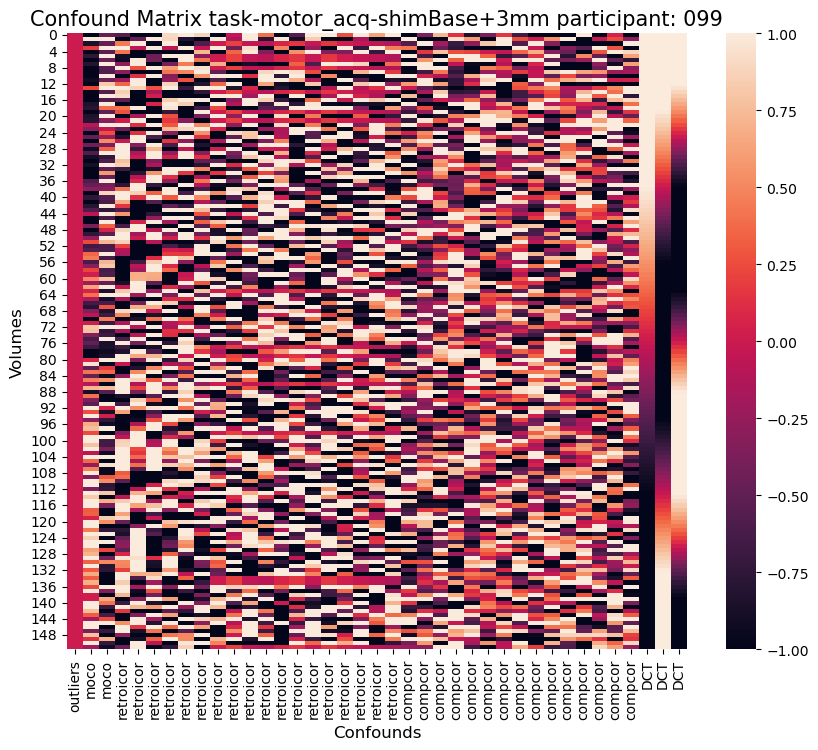

/cerebro/cerebro1/dataset/spine_7T/derivatives/spine_7T_project/denoising/nov25//sub-099/task-motor_acq-shimSlice+3mm//confounds/sub-099_allconfounds_task-motor_acq-shimSlice+3mm_slice010_z.png


<Figure size 640x480 with 0 Axes>

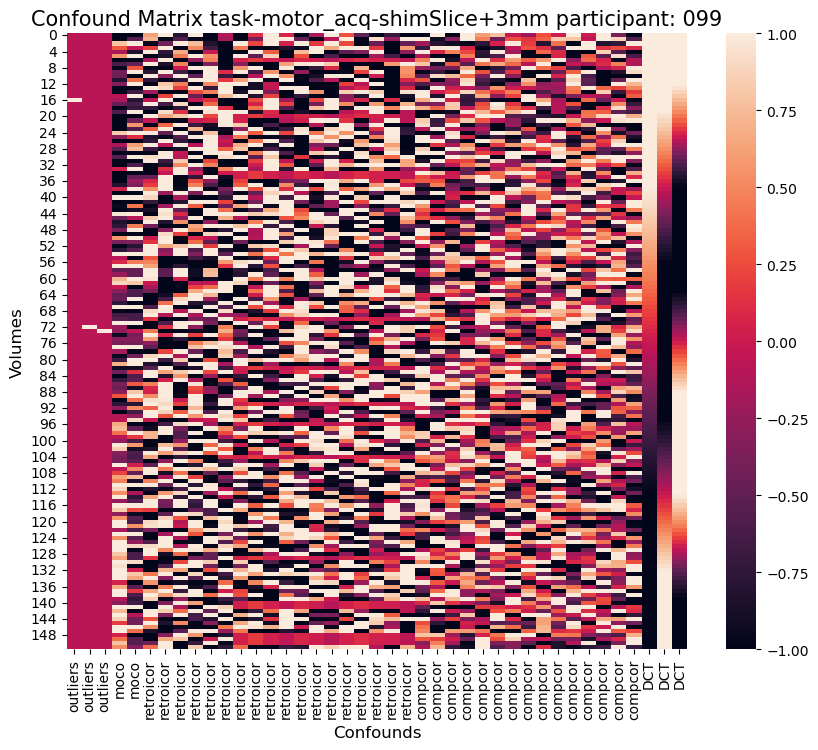

/cerebro/cerebro1/dataset/spine_7T/derivatives/spine_7T_project/denoising/nov25//sub-100/task-motor_acq-shimBase+3mm//confounds/sub-100_allconfounds_task-motor_acq-shimBase+3mm_slice010_z.png


<Figure size 640x480 with 0 Axes>

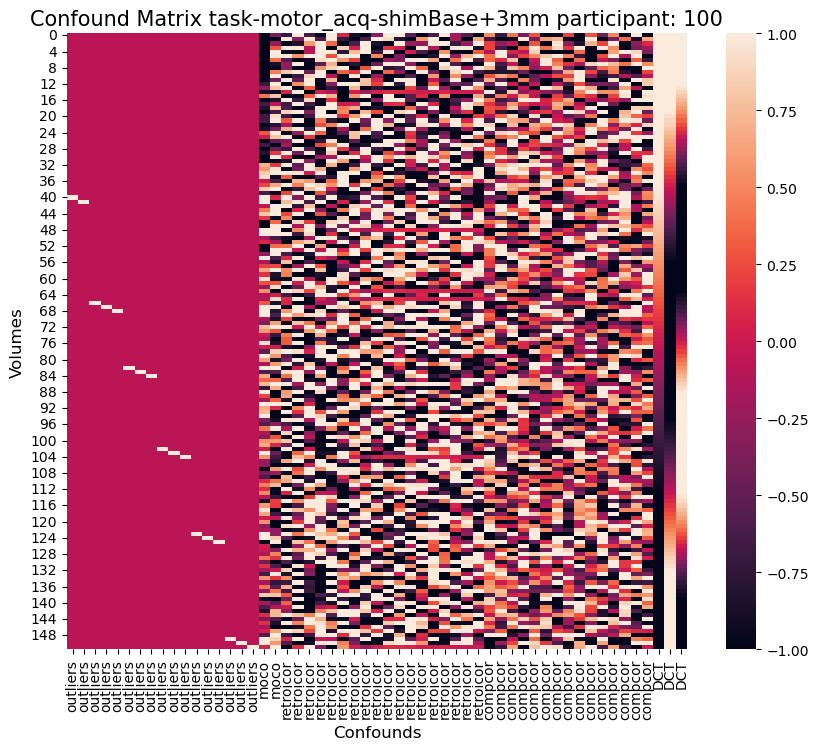

/cerebro/cerebro1/dataset/spine_7T/derivatives/spine_7T_project/denoising/nov25//sub-100/task-motor_acq-shimSlice+3mm//confounds/sub-100_allconfounds_task-motor_acq-shimSlice+3mm_slice010_z.png


<Figure size 640x480 with 0 Axes>

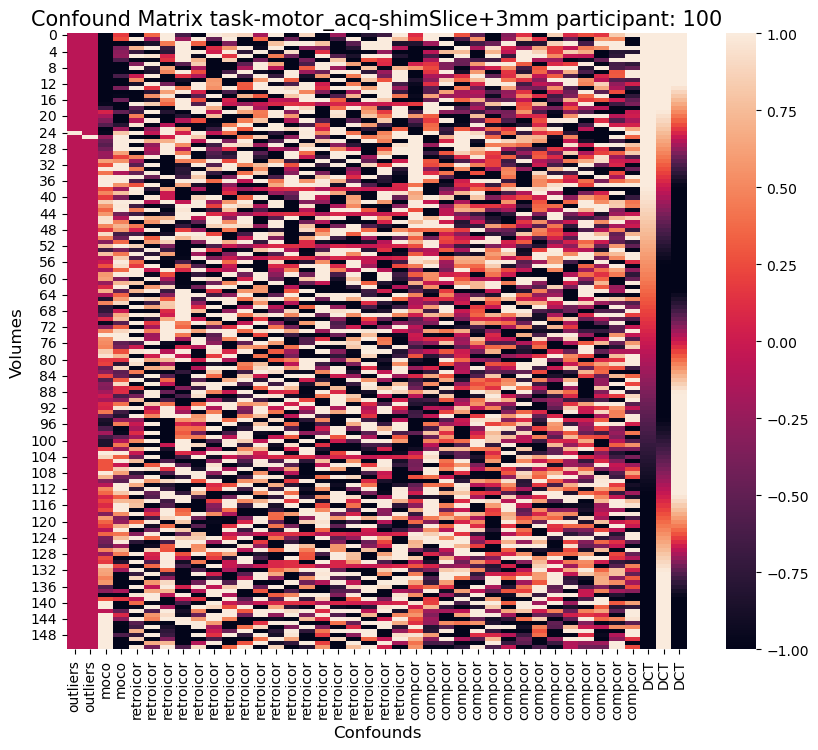

<Figure size 640x480 with 0 Axes>

In [27]:
confounds={}

Counfounds_allsbj={}
for ID_nb, ID in enumerate(config["participants_IDs"]):
    confounds[ID]={}
    for task_name in config["design_exp"]["task_names"]:
        for acq_name in config["design_exp"]["acq_names"]:
            tag = f"task-{task_name}_acq-{acq_name}"
            confounds[ID][tag]={}
            for run_nb, run_name in enumerate(design_exp[ID][tag]):
                confound_infos={'outliers':1,'moco':2,'retroicor':18,'compcor':15,'DCT':3}
                confounds[ID][tag][run_name]=denoising.combine_confounds(
                    ID=ID,
                    task_name=tag,
                    run_name=run_name,
                    confounds_infos=confound_infos,
                    outliers_confounds=True,
                    retroicor_confounds=True,
                    compcor_confounds=True,
                    moco_confounds=True,
                    DCT_confounds=True,
                    slice_wise=True,
                    redo=redo)
                denoising.plot_confound_design(ID=ID,
                                               confound_file=confounds[ID][tag][run_name].split("_slice")[0] + "_slice010_z.txt",
                                               structure="",
                                               task_name=tag,
                                               run_name=run_name,
                                               confounds_infos=confound_infos,
                                               redo=False,
                                               verbose=True)
                


## <font color=#B2D732> <span style="background-color: #4424D6">VI. Image Cleaning</font> </span> 

In [28]:
Clean_image_file={};Clean_meanimage_file={};
filtering_params = {
    "BP": {"high_pass": 0.01, "low_pass": 0.17},
    "HP": {"high_pass": 0.01, "low_pass": None},
    "nofilter": {"high_pass": None, "low_pass": None}}


for filtering in ["HP"]:#,"BP","nofilter","HP"]:
    Clean_image_file[filtering]={}
    for ID_nb, ID in enumerate(config["participants_IDs"]):
        Clean_image_file[filtering][ID]={}
        for task_name in config["design_exp"]["task_names"]:
            for acq_name in config["design_exp"]["acq_names"]:
                tag = f"task-{task_name}_acq-{acq_name}"
                Clean_image_file[filtering][ID][tag]={}
                for run_nb, run_name in enumerate(design_exp[ID][tag]):
                    preproc_dir = config["root_dir"]+ config["derivatives_dir"]+ config["preprocess_dir"]["main_dir"].format(ID)
                    manual_base = config["root_dir"]+ config["derivatives_dir"]+ config["manual_dir"]+ "sub-" + ID + "/func/"
                    manual_seg_glob = f'{manual_base}{tag}/*{run_name}*mean_seg.nii.gz'
                    seg_list = glob.glob(manual_seg_glob)
                    if seg_list:
                        seg_file = seg_list[0] # TRY MANUAL FILES FIRST
                    else:
                        seg_file = glob.glob(preproc_dir+config["seg_files"]["spinalcord"]["dir_func"].format(ID)+ config["seg_files"]["spinalcord"]["seg_func"].format(ID,tag,run_name))[0] # fallback to automatic segmentation

                    Clean_image_file[filtering][ID][tag][run_name]=denoising.clean_images(
                        ID=ID,
                        func_file=glob.glob(preproc_dir+ config["preprocess_dir"]["func_moco"].format(tag)+ config["preprocess_f"]["func_moco"].format(ID, tag, run_name))[0],  # Find functional file,
                        task_name=tag, 
                        run_name=run_name,
                        confounds_file=confounds[ID][tag][run_name],
                        mask_file=seg_file,
                        high_pass=filtering_params[filtering]["high_pass"],
                        low_pass= filtering_params[filtering]["low_pass"], 
                        tag_name=filtering + "_nostd" , #std means the data were z-scored
                        standardize=False,#"zscore", # False if you don't want
                        n_jobs=4,redo=False)
                              
                    

In [12]:
print("=== Preprocessing script finished successfully ===")

=== Preprocessing script finished successfully ===
